In [2]:
#libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
import torch
from STOMPnet import STOMPnet

In [44]:
M=2
L=10
settings_name = f'bitpop_exploit_True_numepi10000_K10_M{M}_N10_T10'
settings_filename = settings_name+".npy"
data_filename = "_trainingdata_" +settings_name+".npy"
seed_idx = 0
agent_embedding_dim = 256
trainedmodel_filename = "_trainingdata_" +settings_name+"_seed"+str(seed_idx)+f"_STOMPnet_{M}_{L}_{agent_embedding_dim}.pt"
loss_filename = "_trainingdata_"+settings_name+"_seed"+str(seed_idx)+"_loggedloss.npy"

In [45]:
outdir = "output/"
# settings = np.load(outdir+settings_filename)
data = np.load(outdir+data_filename, allow_pickle=True).item()
loss_data = np.load(outdir+loss_filename)
# model = np.load(outdir+trainedmodel_filename)

### Dataset analysis

In [46]:
states=np.array(data["states"][seed_idx]) #used only 1 seed
actions=np.array(data["actions"][seed_idx])
episode_times=np.array(data["times"][seed_idx])

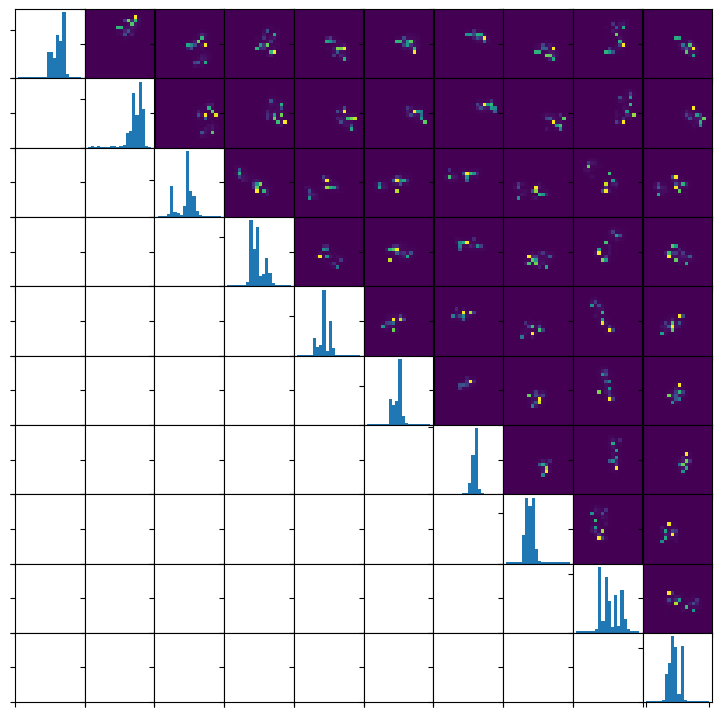

In [47]:
K=states.shape[1]
fig,ax=pl.subplots(K,K,figsize=(9,9))
for rit in range(K):
    for cit in range(K):
        if rit==cit:
            ax[rit,cit].hist(states[:,rit],bins=20)
        if rit<cit:
            heatmap, xedges, yedges = np.histogram2d(states[:,rit], states[:,cit], bins=20)
            extent = [0, 1, 0, 1]
            ax[rit,cit].imshow(heatmap.T, extent=extent, origin='lower')
        ax[rit,cit].set_xticklabels([])
        ax[rit,cit].set_yticklabels([])
fig.subplots_adjust(wspace=0, hspace=0)

In [72]:
orthant_index_seq=np.array([np.sum(np.power(2,np.arange(K))[state>0.5]) for state in states])

In [73]:
np.array([np.power(2,np.arange(K))[state>0.5] for state in states]).shape

/tmp/ipykernel_109/2505405964.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([np.power(2,np.arange(K))[state>0.5] for state in states]).shape


(100000,)

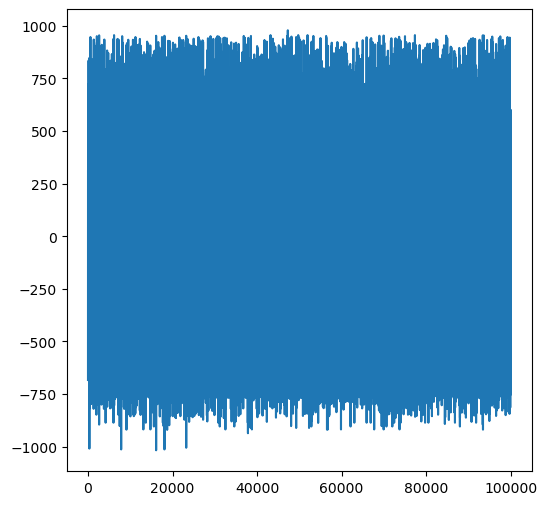

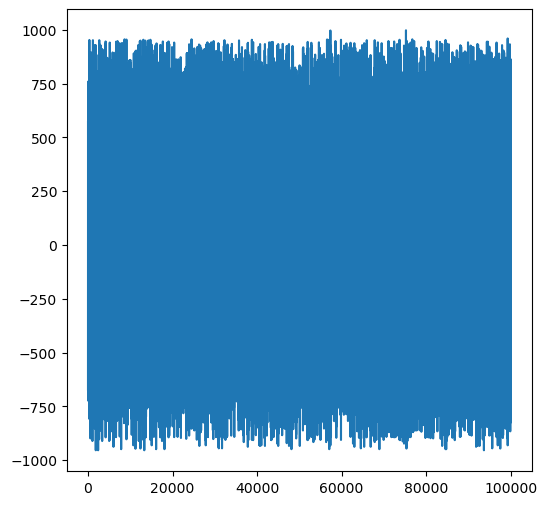

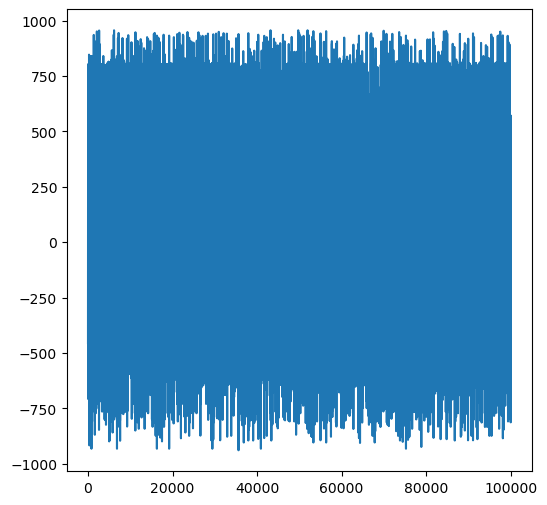

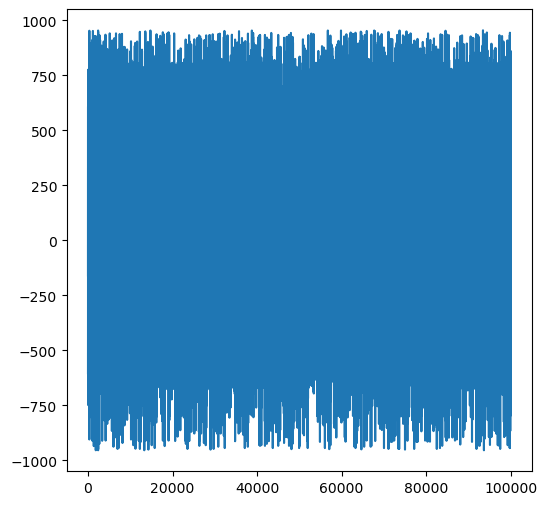

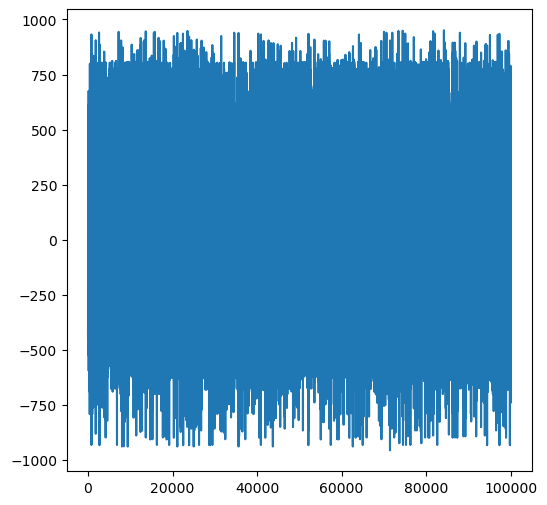

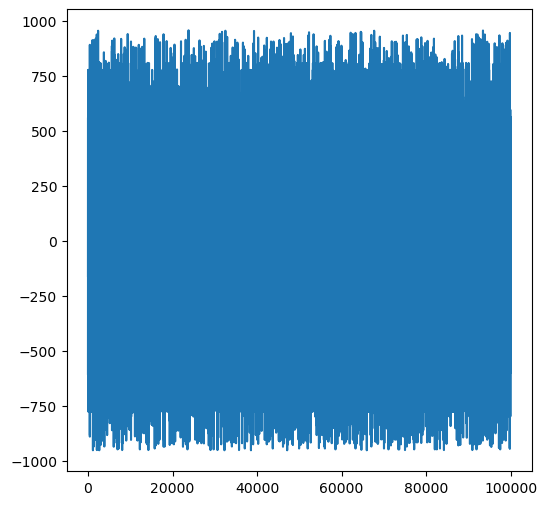

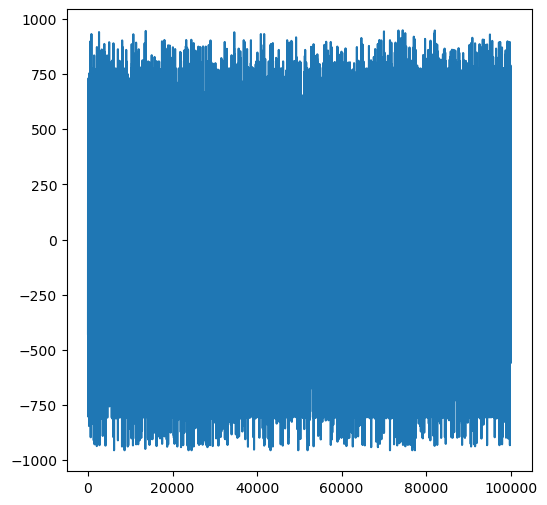

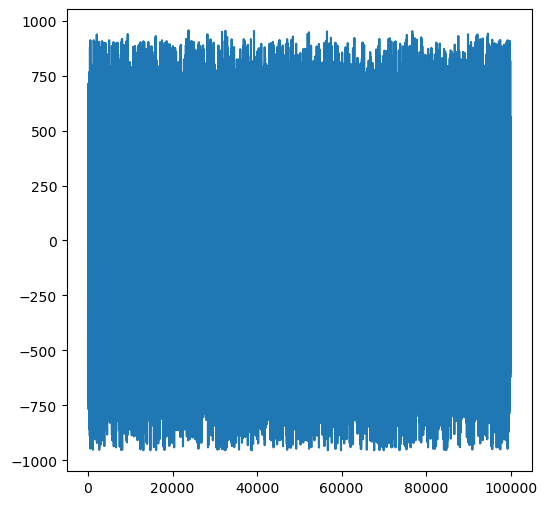

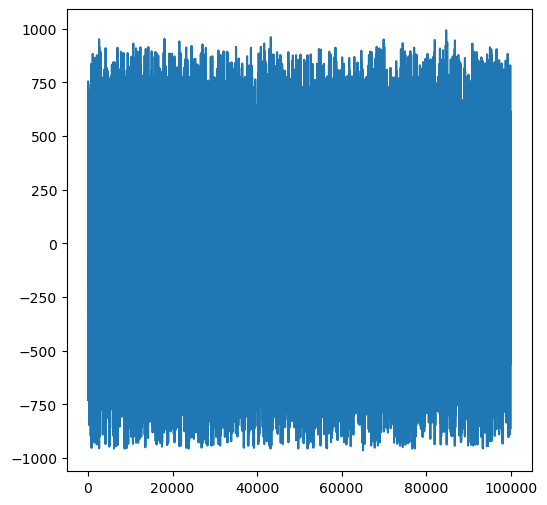

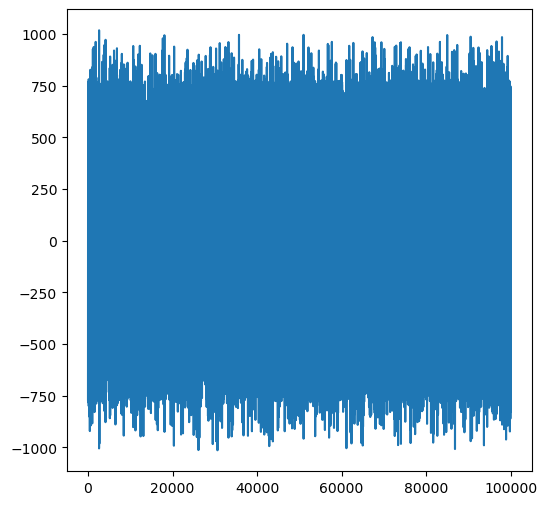

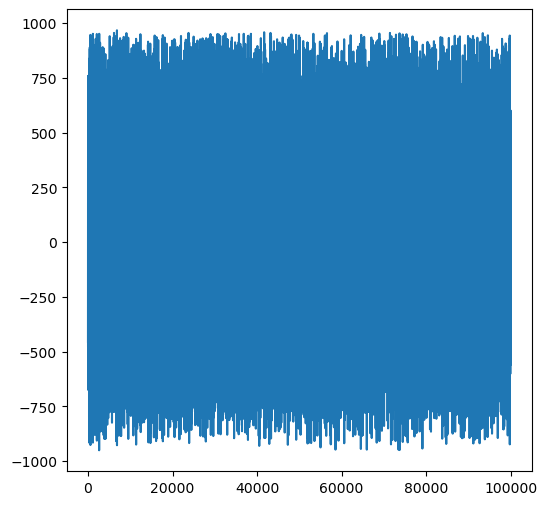

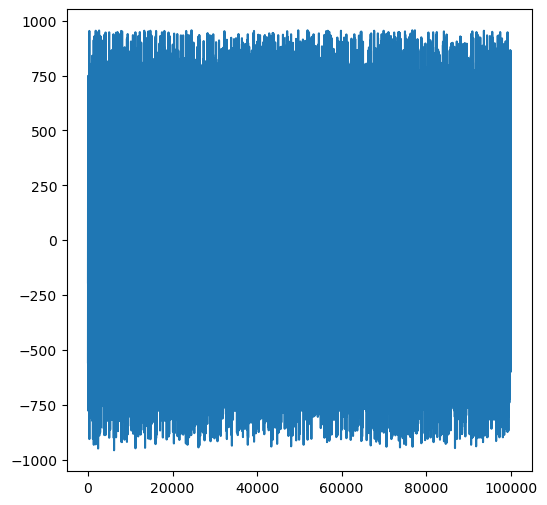

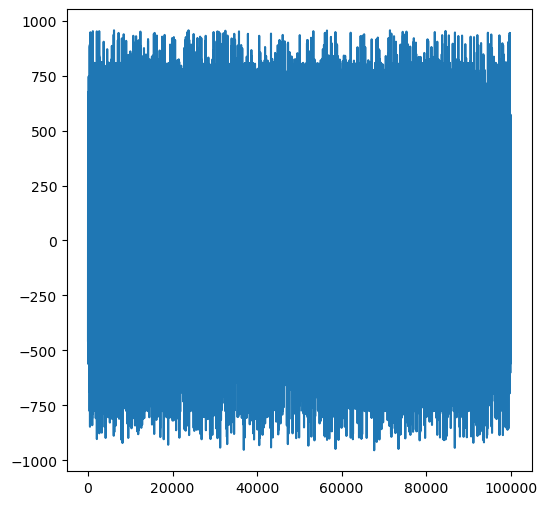

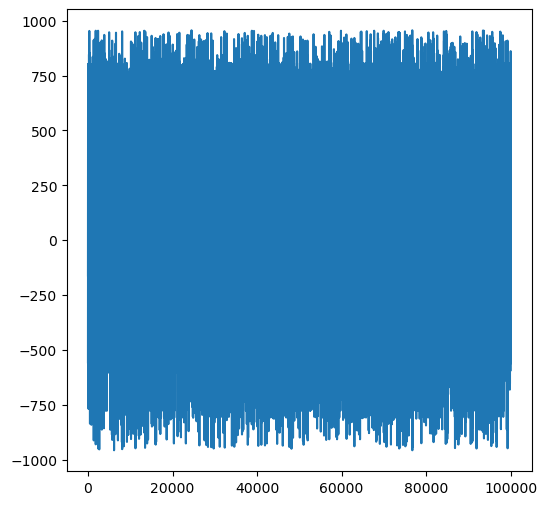

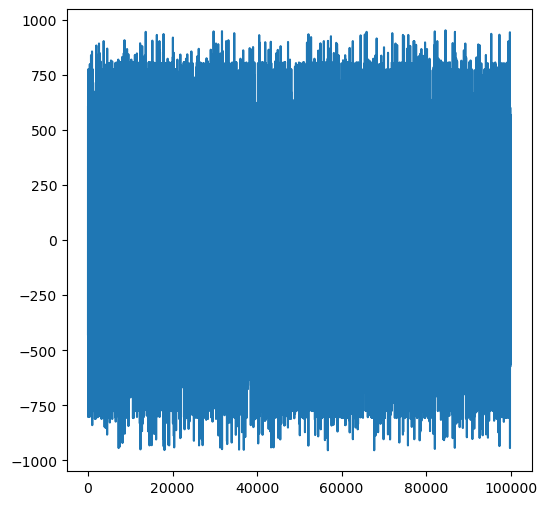

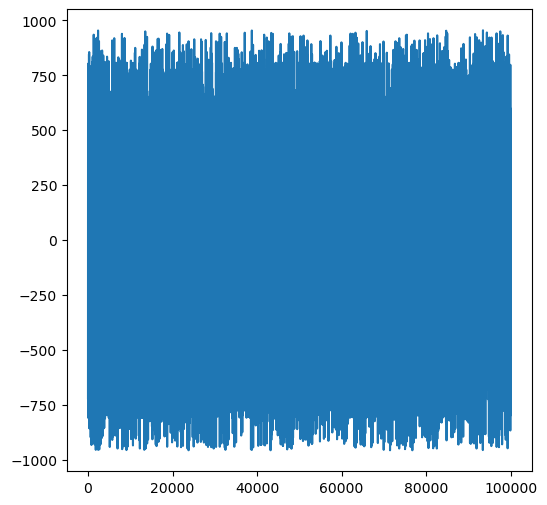

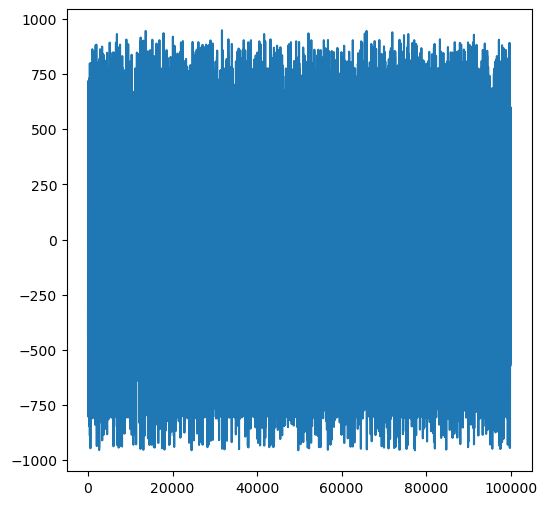

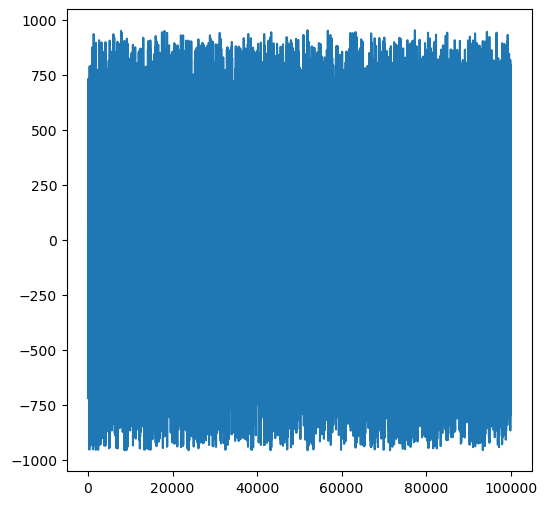

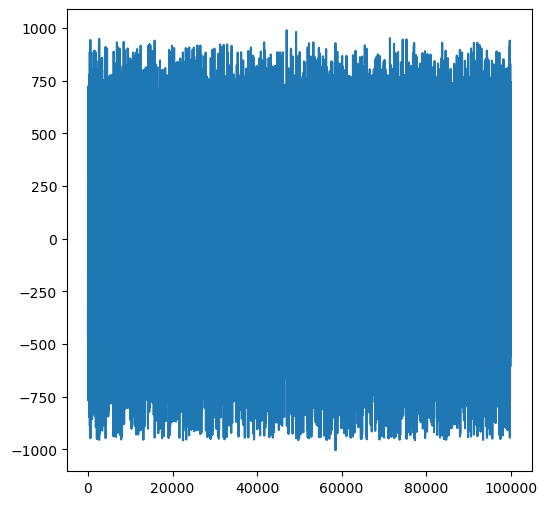

In [74]:
for shift in range(1,20):
    fig,ax=pl.subplots(figsize=(6,6))
    ax.plot(orthant_index_seq[shift:]-orthant_index_seq[:-shift])

/tmp/ipykernel_1320/4098084925.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([r'$10^{'+x.get_text()+'}$' for x in ax.get_xticklabels()]);


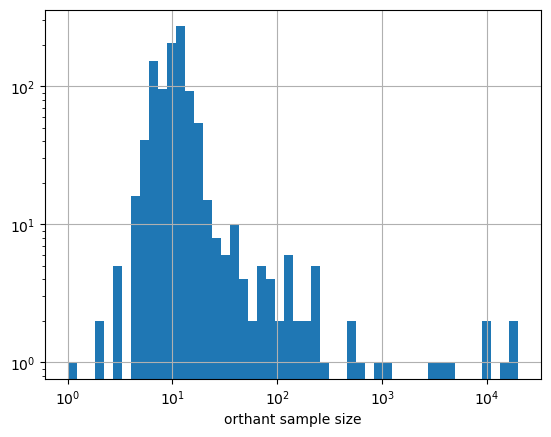

In [48]:
# plot binned states
df = pd.DataFrame(states, columns=range(states.shape[1]))
binned_df=(df>0.5)
outdf=binned_df.groupby(binned_df.columns.tolist(),as_index=False).size()#/len(df)
fig,ax=pl.subplots()
outdf['size'].apply(np.log10).hist(bins=50,ax=ax)
ax.set_xticklabels([r'$10^{'+x.get_text()+'}$' for x in ax.get_xticklabels()]);
ax.set_xlabel('orthant sample size')
ax.set_yscale('log')

In [8]:
trainedmodel_filename.split('.')[0]

'_trainingdata_bitpop_exploit_True_numepi10000_K10_M2_N10_T10_seed1_STOMPnet_2_10_256'

In [49]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device", flush=True)

# Abstraction system
num_abs_agents = data['sys_parameters']['jointagent_groundmodel_paras']['M']
abs_action_space_dim =  int(trainedmodel_filename.split('.')[0].split('_')[-2])  # number of discrete abstract actions
# abstract action policy network parameters
hidden_capacity = 250
enc_hidden_dim = int(hidden_capacity/num_abs_agents)
action_space_dim = 2
state_space_dim = data['sys_parameters']['K']
num_agents = data['sys_parameters']['N']
# Initialize abstraction system model
net = STOMPnet(
            state_space_dim,
            abs_action_space_dim,
            enc_hidden_dim,
            num_agents,
            num_abs_agents,
            action_space_dim=action_space_dim
        )
net.to(device)
state_dict=net.state_dict()
print(f"has {sum(p.numel() for p in state_dict.values())} parameters")

Using cpu device
has 268996 parameters


In [52]:
import itertools
from torch import nn
def get_probs_on_vertices_from_model(net):
    net.eval()
    with torch.no_grad():
        vertex_states = list(itertools.product([0, 1], repeat=10))
        prob_array_store=[]
        f=nn.Softmax(dim=-1)
        for vertex_state in vertex_states:
            logit_array=net(torch.Tensor(vertex_state))
            prob_array_store.append(np.array(f(logit_array)[:,0]))
        return np.array(prob_array_store)
    
def get_probs_on_vertices_from_data(data):
    seed_idx=0
    states=np.array(data["states"][seed_idx]) #used only 1 seed
    actions=np.array(data["actions"][seed_idx])
    vertex_states = np.array(list(itertools.product([0, 1], repeat=10)))
    states=states>0.5
    actions_on_vertices=-np.ones((vertex_states.shape[0],actions.shape[1]))
    got_list=[]
    for i,binarized_state in enumerate(states[:20000]): 
        for j,vertex_state in enumerate(vertex_states):
            if np.all(binarized_state == vertex_state):
                actions_on_vertices[j]=actions[i]
                break
        if np.mod(i,100)==0:
            print(np.sum(actions_on_vertices==-1))
    return actions_on_vertices

In [53]:
prelearning_probs=get_probs_on_vertices_from_model(net)

In [54]:
state_dict = torch.load(outdir + trainedmodel_filename)
net.load_state_dict(state_dict)
postlearning_probs=get_probs_on_vertices_from_model(net)

In [55]:
 data_actions=get_probs_on_vertices_from_data(data)

10230
9950
9770
9640
9500
9380
9260
9140
9060
8940
8850
8760
8650
8530
8450
8370
8260
8170
8100
8020
7930
7830
7750
7670
7600
7520
7480
7380
7300
7240
7180
7130
7040
6970
6920
6890
6830
6740
6670
6600
6510
6430
6360
6280
6230
6200
6140
6090
6010
5930
5850
5820
5770
5710
5670
5600
5510
5450
5390
5360
5300
5230
5180
5140
5080
5030
4970
4920
4830
4780
4720
4680
4630
4590
4540
4490
4470
4430
4370
4340
4290
4240
4180
4140
4120
4100
4070
4050
4030
3990
3970
3920
3860
3830
3800
3780
3710
3670
3650
3610
3570
3510
3480
3440
3380
3330
3310
3260
3220
3190
3170
3160
3130
3090
3080
3060
3020
2990
2980
2950
2930
2910
2890
2870
2850
2830
2810
2750
2720
2660
2620
2600
2580
2550
2550
2540
2520
2480
2450
2410
2380
2350
2330
2300
2270
2260
2250
2210
2210
2210
2160
2110
2090
2040
2010
1980
1960
1960
1930
1930
1920
1900
1900
1880
1850
1850
1800
1790
1760
1730
1710
1700
1680
1660
1650
1640
1620
1610
1580
1580
1570
1550
1540
1520
1520
1500
1480
1480
1440
1430
1420
1420
1420
1410
1360
1350
1330
1330
1310
1310

In [56]:
prelearning_probs

array([[0.4946884 , 0.5       , 0.4997158 , ..., 0.4891402 , 0.4858667 ,
        0.4975521 ],
       [0.5       , 0.5       , 0.49630818, ..., 0.48977172, 0.49015722,
        0.5       ],
       [0.5       , 0.5       , 0.49232885, ..., 0.49039117, 0.4858667 ,
        0.4975521 ],
       ...,
       [0.5       , 0.5       , 0.49848863, ..., 0.49039117, 0.49226037,
        0.5       ],
       [0.5       , 0.5       , 0.49630818, ..., 0.48977172, 0.49015722,
        0.4992429 ],
       [0.49950254, 0.5       , 0.49848863, ..., 0.49039117, 0.49226037,
        0.5       ]], dtype=float32)

In [57]:
postlearning_probs

array([[0.14077128, 0.5       , 0.5       , ..., 0.5       , 0.5       ,
        0.5       ],
       [0.14077128, 0.5       , 0.5       , ..., 0.5       , 0.5       ,
        0.5       ],
       [0.14077128, 0.5       , 0.5       , ..., 0.5       , 0.5       ,
        0.5       ],
       ...,
       [0.14077128, 0.5       , 0.5       , ..., 0.5       , 0.5       ,
        0.5       ],
       [0.14077128, 0.5       , 0.5       , ..., 0.5       , 0.5       ,
        0.5       ],
       [0.14077128, 0.5       , 0.5       , ..., 0.5       , 0.5       ,
        0.5       ]], dtype=float32)

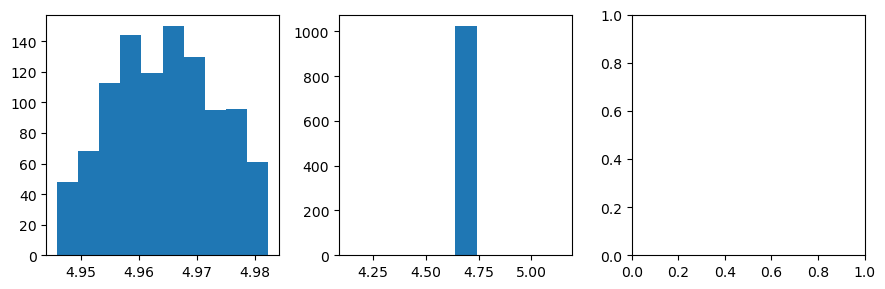

In [58]:
fig,ax=pl.subplots(1,3,figsize=(9,3))
ax[0].hist(np.sum(prelearning_probs,axis=1))
ax[1].hist(np.sum(postlearning_probs,axis=1))
fig.tight_layout()

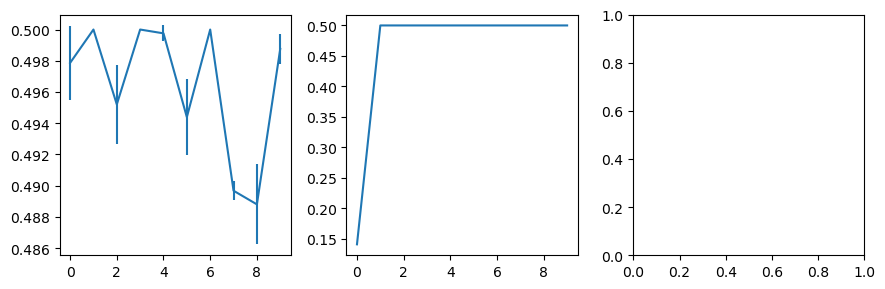

In [59]:
fig,ax=pl.subplots(1,3,figsize=(9,3))
ax[0].errorbar(x=range(len(prelearning_probs[0])),y=np.mean(prelearning_probs,axis=0),yerr=np.std(prelearning_probs,axis=0))
ax[1].errorbar(x=range(len(postlearning_probs[0])),y=np.mean(postlearning_probs,axis=0),yerr=np.std(postlearning_probs,axis=0))
fig.tight_layout()

In [38]:
data_actions=data_actions[data_actions[:,0]!=-1]

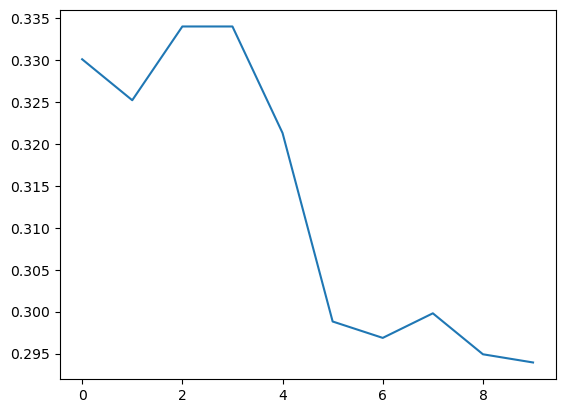

In [60]:
fig,ax=pl.subplots()
ax.plot(np.mean(data_actions,axis=0))

Text(0, 0.5, 'loss')

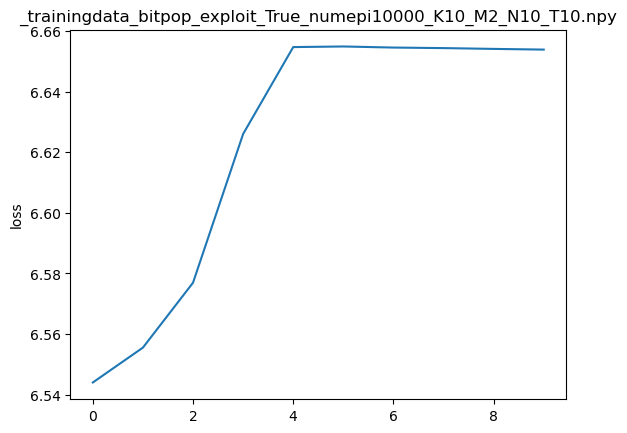

In [61]:
fig,ax=pl.subplots()
ax.plot(loss_data)
ax.set_title(data_filename)
ax.set_ylabel('loss')

In [51]:
loss_data

array([0.00606031, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [46]:
data = np.load(outdir + data_filename, allow_pickle=True).item()
batch_size =16
seed_idx = 0
states = data["states"][seed_idx]
actions = data["actions"][seed_idx]

dataset = CustomDataset(states, actions)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [47]:
actions

array([[1, 1, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 1],
       [1, 1, 1, ..., 0, 0, 0]])

In [34]:
from torch.utils.data import Dataset, DataLoader
class CustomDataset(Dataset):
    def __init__(self, states, actions):
        self.states = states
        self.actions = actions

    def __len__(self):
        return len(self.states)

    def __getitem__(self, idx):
        return self.states[idx], self.actions[idx]

In [43]:
len(train_loader)*16

100000

In [39]:
for i, datat in enumerate(train_loader, 0):
    inputs, labels = datat
    print(f"in:{inputs.shape}, out:{labels.shape}")
    if i>100:
        break

in:torch.Size([16, 10]), out:torch.Size([16, 10])
in:torch.Size([16, 10]), out:torch.Size([16, 10])
in:torch.Size([16, 10]), out:torch.Size([16, 10])
in:torch.Size([16, 10]), out:torch.Size([16, 10])
in:torch.Size([16, 10]), out:torch.Size([16, 10])
in:torch.Size([16, 10]), out:torch.Size([16, 10])
in:torch.Size([16, 10]), out:torch.Size([16, 10])
in:torch.Size([16, 10]), out:torch.Size([16, 10])
in:torch.Size([16, 10]), out:torch.Size([16, 10])
in:torch.Size([16, 10]), out:torch.Size([16, 10])
in:torch.Size([16, 10]), out:torch.Size([16, 10])
in:torch.Size([16, 10]), out:torch.Size([16, 10])
in:torch.Size([16, 10]), out:torch.Size([16, 10])
in:torch.Size([16, 10]), out:torch.Size([16, 10])
in:torch.Size([16, 10]), out:torch.Size([16, 10])
in:torch.Size([16, 10]), out:torch.Size([16, 10])
in:torch.Size([16, 10]), out:torch.Size([16, 10])
in:torch.Size([16, 10]), out:torch.Size([16, 10])
in:torch.Size([16, 10]), out:torch.Size([16, 10])
in:torch.Size([16, 10]), out:torch.Size([16, 10])


Text(0, 0.5, 'loss')

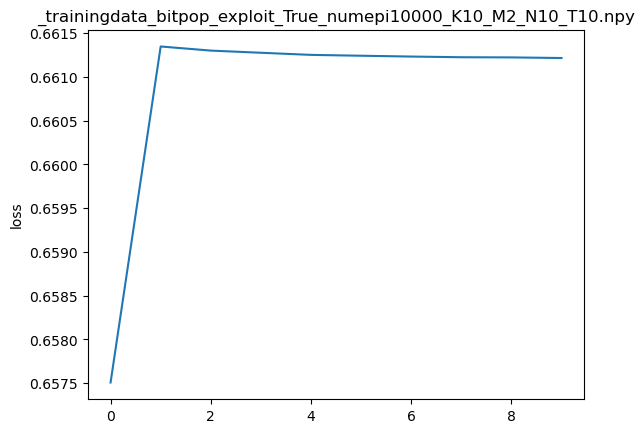

In [26]:
fig,ax=pl.subplots()
ax.plot(loss_data)
ax.set_title(data_filename)
ax.set_ylabel('loss')

Analyze datasets

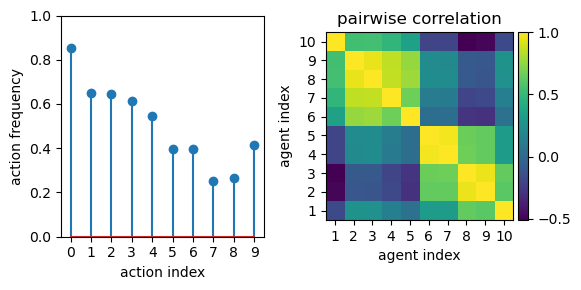

In [62]:
from utils import get_corr_matrix
fig,ax=pl.subplots(1,2,figsize=(6,3))
ax[0].stem(np.mean(actions,axis=0))
ax[0].set_ylim(0,1)
ax[0].set_xticks(range(num_agents))
ax[0].set_ylabel("action frequency")
ax[0].set_xlabel("action index")

corr_matrix = get_corr_matrix(data["actions"][0])
p=ax[1].imshow(corr_matrix, extent=[
                  0.5, num_agents+0.5, 0.5, num_agents+0.5])
ax[1].set_xticks(range(1,data['sys_parameters']['N']+1))
ax[1].set_yticks(range(1,data['sys_parameters']['N']+1))
ax[1].set_xlim(0.5, num_agents+0.5)
ax[1].set_ylim(0.5, num_agents+0.5)
ax[1].set_ylabel('agent index')
ax[1].set_xlabel('agent index')
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(p, cax=cax, orientation='vertical')
ax[1].set_title("pairwise correlation")
fig.tight_layout()

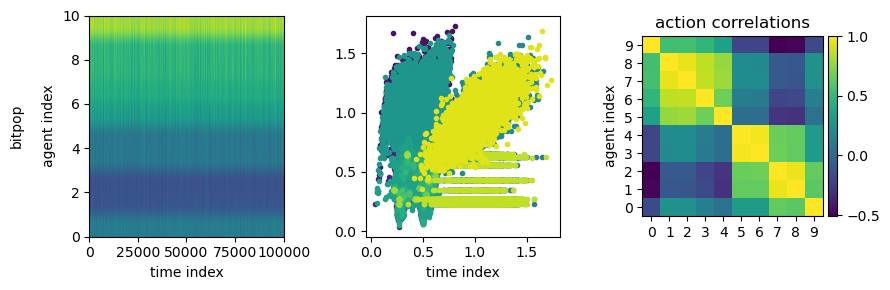

In [63]:
from utils import compare_plot
fig=compare_plot([outdir+data_filename])
fig.savefig(f'{data_filename[:-4]}_summary_fig.pdf', transparent=True, bbox_inches="tight", dpi=300)


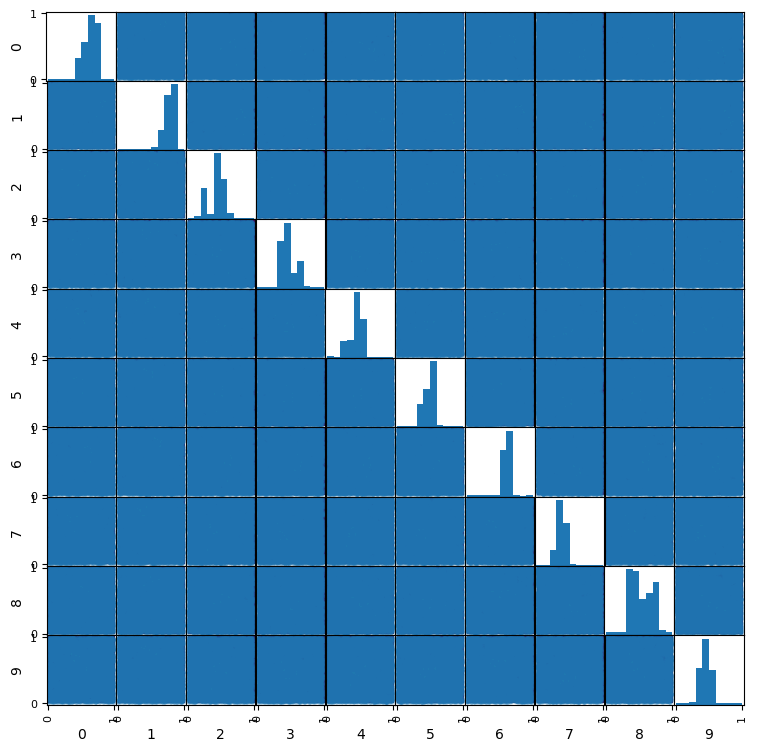

In [10]:
df = pd.DataFrame(states, columns=range(states.shape[1]))
axis_array=pd.plotting.scatter_matrix(df, alpha=0.2, figsize=(9,9));
for rit,row in enumerate(axis_array):
    for cit,axis in enumerate(row):
        if rit!=cit:
            heatmap, xedges, yedges = np.histogram2d(states[:,rit], states[:,cit], bins=50)
            extent = [0, 1, 0, 1]
#             axis.remove()
            axis.imshow(heatmap.T, extent=extent, origin='lower')

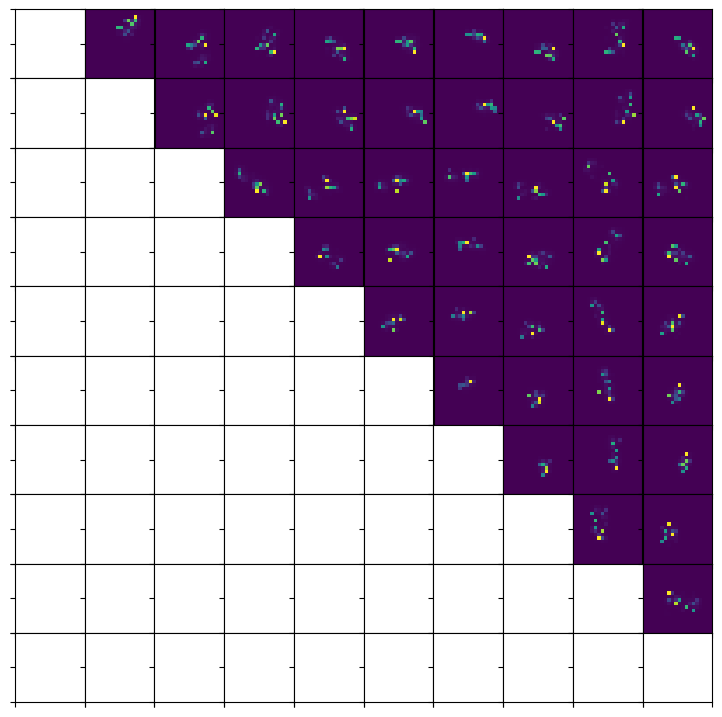

In [11]:
fig,ax=pl.subplots(*axis_array.shape,figsize=(9,9))
for rit,row in enumerate(axis_array):
    for cit,axis in enumerate(row):
        if rit<cit:
            heatmap, xedges, yedges = np.histogram2d(states[:,rit], states[:,cit], bins=20)
            extent = [0, 1, 0, 1]
#             axis.remove()
            ax[rit,cit].imshow(heatmap.T, extent=extent, origin='lower')
        ax[rit,cit].set_xticklabels([])
        ax[rit,cit].set_yticklabels([])
fig.subplots_adjust(wspace=0, hspace=0)
# fig.tight_layout()

/tmp/ipykernel_1694/3604754051.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([r'$10^{'+x.get_text()+'}$' for x in ax.get_xticklabels()]);


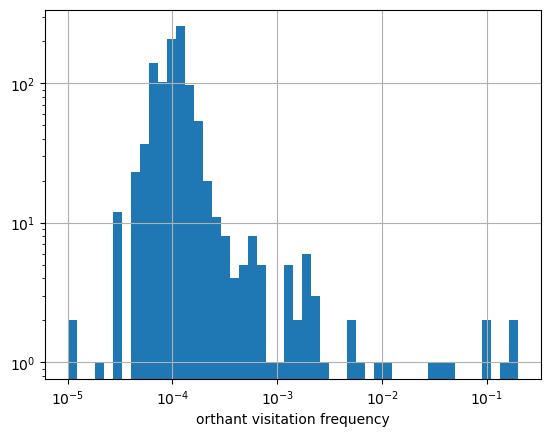

In [13]:
fig,ax=pl.subplots()
outdf['size'].apply(np.log10).hist(bins=50,ax=ax)
ax.set_xticklabels([r'$10^{'+x.get_text()+'}$' for x in ax.get_xticklabels()]);
ax.set_xlabel('orthant visitation frequency')
ax.set_yscale('log')